In [63]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import toeplitz, circulant
from scipy.stats import linregress as linreg

import scipy.fftpack as fft

import sympy as smp

from pytex import *

from scipy.integrate import quadrature as quad

from matplotlib import animation
animation.rcParams['animation.writer'] = 'ffmpeg'
from IPython.display import HTML

In [2]:
matplotlib.rcParams.update({'font.size': 12})

# Parameters

In [126]:
# parameters ************************************************************
m = 6 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = .5 #max CFL number at which to run

Re = 100

t0, t_final = 0, 40

# calcuated parameters **************************************************
h = L/m
k = CFL*h
t_steps = int((t_final-t0)/k)

mux, muy = m+1, m+2
mvx, mvy = m+2, m+1
mpx, mpy = m+2, m+2

# Functions

In [131]:
def update_ghost_diffusion(us, vs, ps, h, k, extrapolate=True):
    # update u
    #   vertical
    us[:, 0] = np.zeros(len(us[:, 0]))
    us[:,-1] = np.zeros(len(us[:,-1]))
    #   horizontal
    us[0]  = 2*     k*np.diff(ps[ 1])/h  - extrapolate*us[ 1]
    us[-1] = 2*(1 + k*np.diff(ps[-2])/h) - extrapolate*us[-2]
    #   average corners
    us[ 0, 0] /= 2
    us[ 0,-1] /= 2
    us[-1, 0] /= 2
    us[-1,-1] /= 2
    
    # update v
    #   horizontal
    vs[ 0] = np.zeros(len(vs[ 0,:]))
    vs[-1] = np.zeros(len(vs[-1,:]))
    #   vertical
    vs[:, 0] = 2*k*np.diff(ps[:, 1])/h - extrapolate*vs[:, 1]
    vs[:,-1] = 2*k*np.diff(ps[:,-2])/h - extrapolate*vs[:,-2]
    #   average corners
    vs[ 0, 0] /= 2
    vs[ 0,-1] /= 2
    vs[-1, 0] /= 2
    vs[-1,-1] /= 2
    
def ave_x(edge):
    return (edge[:,:-1] + edge[:,1:])/2
    
def ave_y(edge):
    return (edge[:-1,:] + edge[1:,:])/2

def ave_c(edge):
    ave = edge[:,:-1] + edge[:,1:]
    return (ave[:-1,:] + ave[1:,:])/4

def up_wind(us, vs, h, k):
    # compute (u,v).grad(u)
    U, V = ave_x(us[1:-1,:]), ave_x(vs[:,1:-1])
    pos_id = np.greater(U, 0)
    F = pos_id*us[1:-1,:-1] + np.logical_not(pos_id)*us[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*us[:-1,1:-1] + np.logical_not(pos_id)*us[1:,1:-1]
    # get v on vertical edges
    V = ave_c(vs[:,1:-1])
    u_adv = 1/h * (us[1:-1, 1:-1] * np.diff(F,1,1) + V*np.diff(G,1,0))
    
    # compute (u,v).grad(v)
    U, V = ave_y(us[1:-1,:]), ave_y(vs[:,1:-1])
    pos_id = np.greater(U, 0)
    F = pos_id*vs[1:-1,:-1] + np.logical_not(pos_id)*vs[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*vs[:-1,1:-1] + np.logical_not(pos_id)*vs[1:,1:-1]
    # get u on horizontal edges
    U = ave_c(us[1:-1,:])
    v_adv = 1/h * (vs[1:-1, 1:-1] * np.diff(G,1,0) + U*np.diff(F,1,1))
    
    return u_adv, v_adv
    

In [148]:
u_adv, v_adv = up_wind(us, vs, h, k)
print(u_adv)
print(v_adv)

[[ 1.5         1.90192379  0.80384758 -0.69615242 -1.09807621]
 [ 1.5         1.90192379  0.80384758 -0.69615242 -1.09807621]
 [ 1.5         1.90192379  0.80384758 -0.69615242 -1.09807621]
 [ 1.5         1.90192379  0.80384758 -0.69615242 -1.09807621]
 [ 1.5         1.90192379  0.80384758 -0.69615242 -1.09807621]
 [ 3.          2.30384758  0.80384758 -0.29422863  0.40192379]]
[[ 1.50000000e+00  1.50000000e+00  1.50000000e+00  1.50000000e+00
   1.50000000e+00 -9.99200722e-16]
 [ 1.90192379e+00  1.90192379e+00  1.90192379e+00  1.90192379e+00
   1.90192379e+00 -6.96152423e-01]
 [ 8.03847577e-01  8.03847577e-01  8.03847577e-01  8.03847577e-01
   8.03847577e-01 -2.19615242e+00]
 [-6.96152423e-01 -6.96152423e-01 -6.96152423e-01 -6.96152423e-01
  -6.96152423e-01 -3.29422863e+00]
 [-1.09807621e+00 -1.09807621e+00 -1.09807621e+00 -1.09807621e+00
  -1.09807621e+00 -2.59807621e+00]]


In [114]:
print(U.shape)
print(V.shape)
print(F.shape)
print(G.shape)
print(us[1:-1, 1:-1].shape)

(32, 32)
(32, 31)
(32, 32)
(33, 31)
(32, 31)


In [147]:
#us = np.zeros((muy, mux))
xs = np.linspace(0, np.pi, mux)
us = np.tile(np.sin(xs), (muy, 1))
#vs = np.zeros((mvy, mvx))
ys = np.linspace(0, np.pi, mvy)
vs = np.tile(np.sin(ys), (mvx,1)).T
ps = np.ones((mpy, mpx))
ps[0]   *= 2
ps[:,0] *= 2
update_ghost_diffusion(us, vs, ps, h, k)

for arr in (us, vs, ps):
    print(arr)
    
print(u_adv)

[[-0.5       -0.5       -0.8660254 -1.        -0.8660254 -0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.         0.5        0.8660254  1.         0.8660254  0.5
   0.       ]
 [ 0.5        1.5        1.1339746  1.         1.1339746  1.5
   1.       ]]
[[-0.5        0.         0.         0.         0.         0.
   0.        -0.5      ]
 [-0.5        0.5        0.5        0.5        0.5        0.5
   0.5       -0.5      ]
 [-0.8660254  0.8660254  0.8660254  0.8660254  0.8660254  0.8660254
   0.8660254 -0.8660254]
 [-1.         1.         1.         1.         1.         1.
   1.        -1.       ]
 [-0.8660254  0.8660254  0.8660254  0.8

# Solve

In [4]:
us = np.zeros((mux, muy))
vs = np.zeros((mvx, mvy))
ps = np.zeros((mpx, mpy))

for i in (1, t_steps+1):
    # iterate to calculate u*
    for iteration in range(3):
        

'\nfor i in (1, t_steps+1):\n    # iterate to calculate u*\n    for iteration in range(3):\n        '

<IPython.core.display.Javascript object>


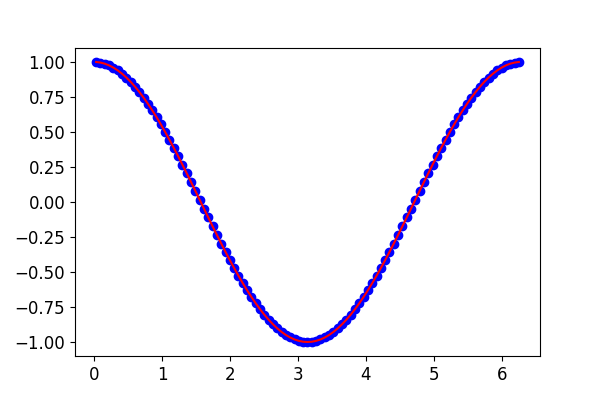

In [9]:
a, b = 0, 2*np.pi
n = 100
h = (b-a)/(n-1)
grid = np.linspace(a, b, n)
centers = np.linspace(a+h/2, b-h/2, n-1)

ys = np.sin(grid)
ds = np.diff(ys)/h

fig = plt.figure(figsize=(6,4))
plt.plot(centers, ds, 'bo')
plt.plot(centers, np.cos(centers), 'r-')
plt.show()

# Compare to GGS82 data

<IPython.core.display.Javascript object>


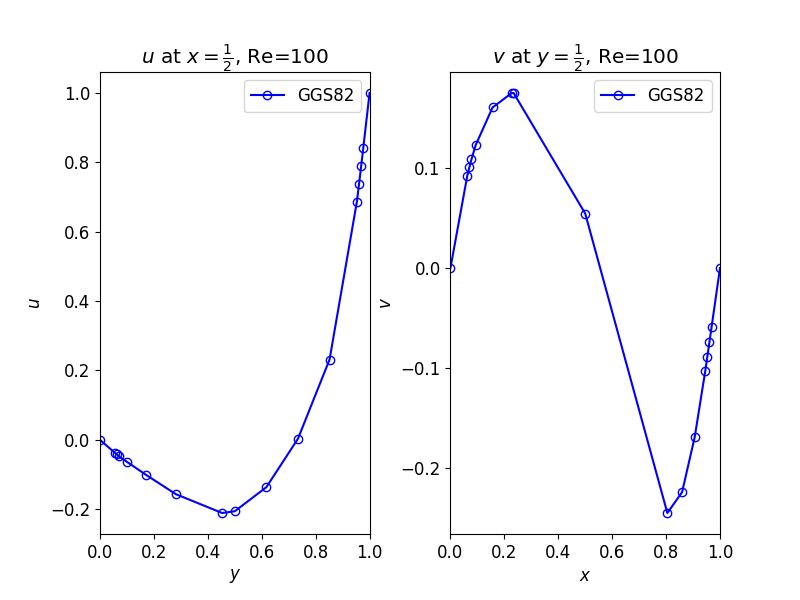

In [64]:
#data locations for u component of velocity
ys_u = [1,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0]
xs_u = [.5]*len(ys_u)

#data locations for v component of velocity
xs_v = [1,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,
        0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0]
ys_v = [.5]*len(xs_v)

# Determine the values for comparison to GS82
if Re == 100:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.84123,0.78871,0.73722,0.68717,0.23151,
              0.00332,-0.13641,-0.20581,-0.21090,-0.15662,
              -0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0];
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,
              -0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,
              0.12317,0.10890,0.10091,0.09233,0];
elif Re == 1000:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,
              0.05702,-0.06080,-0.10648,-0.27805,-0.38289,-0.29370,
              -0.22220,-0.20196,-0.18109,0];
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.21388,-0.27669,-0.33714,-0.39188,-0.51550,
              -0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,
              0.32627,0.30353,0.29012,0.27485,0];

    

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,6))
plt.subplots_adjust(wspace=.3)

ax1.set_xlim((0,1))
ax1.set_title('$u$ at $x=\\frac{1}{2}$, Re=%d' % Re)
ax1.set_xlabel('$y$')
ax1.set_ylabel('$u$')
ax1.plot(ys_u, uGGS82, 'bo-', fillstyle='none', label='GGS82')
ax1.legend()

ax2.set_xlim((0,1))
ax2.set_title('$v$ at $y=\\frac{1}{2}$, Re=%d' % Re)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v$')
ax2.plot(xs_v, vGGS82, 'bo-', fillstyle='none', label='GGS82')
ax2.legend()

plt.show()

In [94]:
x = np.arange(10)
idx = np.arange(2,8)

In [95]:
x[idx] = np.ones(idx.shape)

In [96]:
x

array([0, 1, 1, 1, 1, 1, 1, 1, 8, 9])

In [13]:
def increment(x):
    x[0] = x[0] + 1

In [16]:
x = np.arange(3)
increment(x)
increment(x)

In [17]:
x

array([2, 1, 2])